In [167]:
import matplotlib

import pandas as pd
import numpy as np
import dateutil
import warnings
warnings.filterwarnings('ignore')

def transform(row):
    if row == 'BUY':
        return 1
    return -1
filename = r"D:\Excel File\Nhat_Ky_Giao_Dich.xlsx"
df= pd.read_excel(filename, sheet_name="nhatky", header=1, usecols="B:I", names = ["Broker", "Date", "Action", "Ticker", "Price", "Volume","Value", "Reason"])


# drop the row with all NaN
#df = df.dropna(how='all')
df['Action'] = df['Action'].apply((lambda x: transform(x)))
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
#df['Volume'] = df['Volume'].astype(int)
# filter date > 2021-01-01
df = df[df['Date'] > dateutil.parser.parse("2021-10-05")]

# accumulate the Volumn of each ticker by using Volumn = Volumn * Action
df['Volume'] = df['Volume'] * df['Action']

# group by Ticker and sum the Volumn, return data frame
df = df.groupby('Ticker').agg({'Volume': 'sum'})
df = df.sort_values(by='Volume', ascending=False)
df.reset_index(inplace=True)
df = df[df['Volume'] > 0]

porfolio = df


In [168]:
# download vietnam stock data from cafef

# use pandas to get latest working date, include today if today is a working day (not weekend)
latest_working_date = pd.to_datetime('today')
if latest_working_date.weekday() == 5:
    latest_working_date = latest_working_date - pd.Timedelta(days=1)
elif latest_working_date.weekday() == 6:
    latest_working_date = latest_working_date - pd.Timedelta(days=2)

# convert to string ddmmYYYY
print("latest_working_date: ", latest_working_date)
#https://cafef1.mediacdn.vn/data/ami_data/20240315/CafeF.SolieuGD.15032024.zip
url = "https://cafef1.mediacdn.vn/data/ami_data/{}/CafeF.SolieuGD.{}.zip".format(latest_working_date.strftime('%Y%m%d'), latest_working_date.strftime('%d%m%Y'))
print("url: ", url)


import requests
import zipfile
import os
import io
# download above zip file to local

filename = url.split("/")[-1]
folder = r"D:\Excel File\Stock Data"

# check if file exist or not, if not then download
if not os.path.exists(os.path.join(folder, filename)):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    # create folder if not exist
    if not os.path.exists(folder):
        os.makedirs(folder)

    # store zip file to folder
    with open(os.path.join(folder, filename), 'wb') as f:
        print("store zip file")
        print("filename: ", filename)
        f.write(r.content)

    # list the folder
    print("list the folder")
    print(os.listdir(folder))
    z.extractall(folder)

    # remove file that have NN in the name
    for the_file in os.listdir(folder):
        if "NN" in the_file and "zip" not in the_file:
            file_path = os.path.join(folder, the_file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            except Exception as e:
                print(e)
    # clean up zip file
    z.close()


# use pandas to merge all csv file in the folder to one file, csv file need to have the last working date dd.mm.YYYY in the name
import glob
import os
import pandas as pd
# get all csv file in the folder
all_files = glob.glob(os.path.join(folder, "*.csv"))
# for over each file and merge merge dataframe if the name contain the last working date 

df = pd.DataFrame()
header = ["Ticker", "Date", "Open", "High", "Low", "Close", "Volume"]
for filename in all_files:
    if latest_working_date.strftime('%d.%m.%Y') in filename:
        print("filename: ", filename)
        df = pd.concat([df, pd.read_csv(filename, header=0, names=header, parse_dates=True)], ignore_index=True)


# convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='coerce')
print(df.dtypes)
# filter latest date only
df = df[df['Date'] == np.max(df['Date'])]
print(df.head(5))

price = df


latest_working_date:  2024-03-15 22:40:25.260303
url:  https://cafef1.mediacdn.vn/data/ami_data/20240315/CafeF.SolieuGD.15032024.zip
filename:  D:\Excel File\Stock Data\CafeF.HNX.15.03.2024.csv
filename:  D:\Excel File\Stock Data\CafeF.HSX.15.03.2024.csv
filename:  D:\Excel File\Stock Data\CafeF.UPCOM.15.03.2024.csv
Ticker            object
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object
  Ticker       Date  Open  High   Low  Close  Volume
0    AAV 2024-03-15   3.8   3.8   3.7    3.8  283007
1    ADC 2024-03-15  19.6  19.6  19.6   19.6     100
2    ALT 2024-03-15  13.8  14.4  13.8   14.4     700
3    AMC 2024-03-15  18.3  18.3  18.3   18.3     100
4    AME 2024-03-15   8.2   8.2   7.7    7.7    1017


  Ticker  Volume  Close
0    VIB  6400.0  22.50
1    VCG  5300.0  24.55
2    PVS  3100.0  37.90
3    DHC  2800.0  45.90
4    VCI  2600.0  53.70
5    IDC  2100.0  59.80


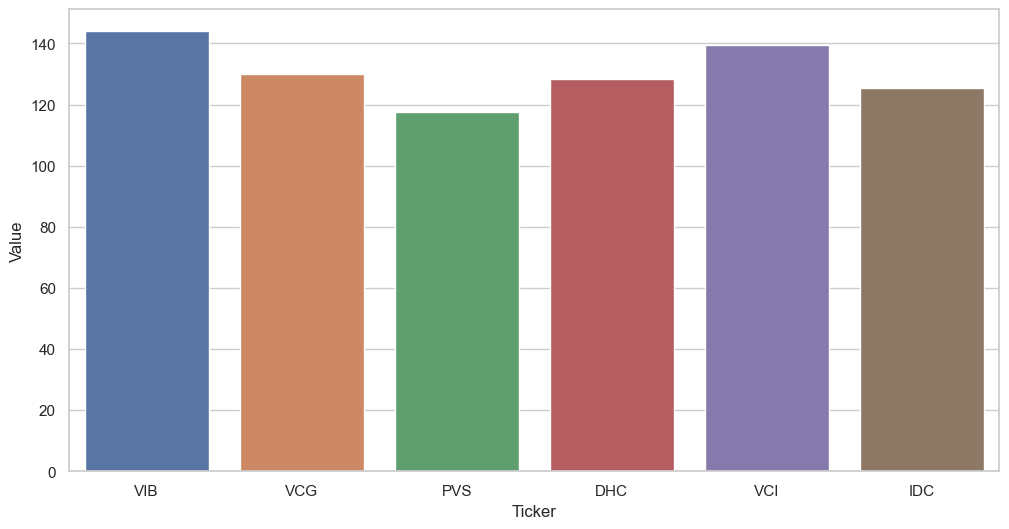

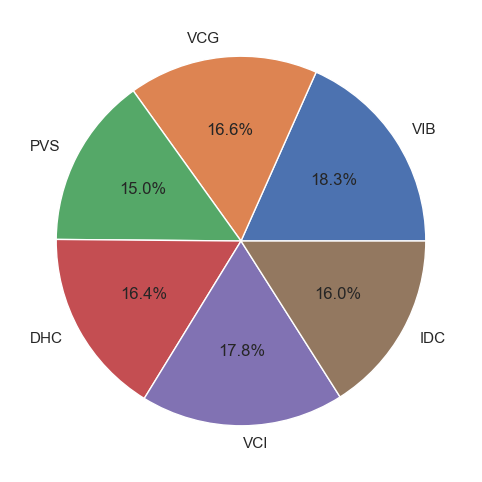

In [174]:
# merge porfolio and price by Ticker, return porfolio Volume and price Close
price = price[["Ticker", "Close"]]
df = pd.merge(porfolio, price, on='Ticker', how='left')
print(df.head(10))

# use seaborn to plot the porfolio value by Ticker
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
df["Value"] = df["Volume"] * df["Close"]/1000
ax = sns.barplot(x="Ticker", y="Value", data=df)
plt.show()

# draw pie chart with nice style
plt.figure(figsize=(12, 6))
plt.pie(df["Value"], labels=df["Ticker"], autopct='%1.1f%%')
plt.show()


In [ ]:
# write a function to allocate money to each stock in the porfolio
def allocate_money(porfolio, money):
    porfolio["Value"] = porfolio["Volume"] * porfolio["Close"]
    porfolio["Weight"] = porfolio["Value"] / porfolio["Value"].sum()
    porfolio["Allocate"] = porfolio["Weight"] * money
    return porfolio